In [4]:
from mestrado import qif
from mestrado import datasets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("seaborn-whitegrid")

/home/felipegiori/Mestrado/research/src/mestrado/qif.py:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if vulnerability_type is 'average' or vulnerability_type is 'avg':
/home/felipegiori/Mestrado/research/src/mestrado/qif.py:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if vulnerability_type is 'average' or vulnerability_type is 'avg':
/home/felipegiori/Mestrado/research/src/mestrado/qif.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif vulnerability_type is 'maximum' or vulnerability_type is 'max':
/home/felipegiori/Mestrado/research/src/mestrado/qif.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif vulnerability_type is 'maximum' or vulnerability_type is 'max':
/home/felipegiori/Mestrado/research/src/mestrado/qif.py:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if leakage_type is 'multiplicative' or leakage_type is 'mult':
/home/felipegiori/Mestrado/research/src/mestrado/qif.py:91: SyntaxWarning: "is" 

In [5]:
adult = datasets.load_data_adult()
german = datasets.load_data_german()
breast_w = datasets.load_data_breastw()
breast_tumor = datasets.load_data_breast_tumor()
cholesterol = datasets.load_data_cholesterol()
balance_scale = datasets.load_data_balance_scale()
sensory = datasets.load_data_sensory()
cleveland = datasets.load_data_heart_disease()

AttributeError: module 'mestrado.datasets' has no attribute 'load_data_adult'

In [3]:
# Functions
def joint_distribution(df, x, y):
    joint_dist = df.groupby([x, y]).size().unstack()
    joint_dist.columns = joint_dist.columns.get_level_values(0)
    joint_dist = joint_dist.div(joint_dist.sum().sum())
    return joint_dist.fillna(0)


def avg_mult_bayes_leakage(joint_dist):
    Y = joint_dist.columns
    posterior_vulnerability = 0
    prior_vulnerability = joint_dist.sum(axis=1).max()
    for y in Y:
        posterior_vulnerability = posterior_vulnerability + joint_dist[y].max()
    return posterior_vulnerability/prior_vulnerability


def max_mult_bayes_leakage(joint_dist):
    posterior_vulnerability = joint_dist.div(joint_dist.sum(axis=0), axis=1).values.max()
    prior_vulnerability = joint_dist.sum(axis=1).max()
    return posterior_vulnerability/prior_vulnerability


def mult_bayes_leakage(joint_dist):
    prior_vulnerability = joint_dist.sum(axis=1).max()
    posterior_vulnerability = joint_dist.div(joint_dist.sum(axis=0), axis=1)/prior_vulnerability
    return posterior_vulnerability.max(axis=0)


def compute_flows(df, x, y='target', verbose=False):
    joint_dist = joint_distribution(df, x, y)
    avg_dir_flow = np.round(avg_mult_bayes_leakage(joint_dist), 2)
    avg_rev_flow = np.round(avg_mult_bayes_leakage(joint_dist.T), 2)
    max_dir_flow = np.round(max_mult_bayes_leakage(joint_dist), 2)
    max_rev_flow = np.round(max_mult_bayes_leakage(joint_dist.T), 2)
    
    if(verbose):
        print("Avg Direct Flow: ", np.round(avg_dir_flow, 2))
        print("Avg Reverse Flow: ", np.round(avg_rev_flow, 2))
        print("Max Direct Flow: ", np.round(max_dir_flow, 2))
        print("Max Reverse Flow: ", np.round(max_rev_flow, 2))
    
    return avg_dir_flow, avg_rev_flow, max_dir_flow, max_rev_flow

In [8]:
data = []
data.append([breast_w, 'Anticausal', "Cell_Shape_Uniformity", "target", "breast_w"])
data.append([breast_w, 'Anticausal', "Cell_Size_Uniformity", "target", "breast_w"])
data.append([breast_w, 'Anticausal', "Single_Epi_Cell_Size", "target", "breast_w"])
data.append([breast_w, 'Anticausal', "Clump_Thickness", "target", "breast_w"])
data.append([balance_scale, 'Causal', "right_weight", "target", "balance_scale"])
data.append([balance_scale, 'Causal', "right_distance", "target", "balance_scale"])
data.append([balance_scale, 'Causal', "left_weight", "target", "balance_scale"])
data.append([balance_scale, 'Causal', "left_distance", "target", "balance_scale"])
data.append([breast_tumor, 'Anticausal', 'inv_nodes', 'tumor_size', "breast_tumor"])
data.append([breast_tumor, 'Anticausal', 'deg_malig', 'tumor_size', "breast_tumor"])
data.append([cholesterol, 'Anticausal', 'fbs', 'chol', "cholesterol"])
data.append([sensory, "Causal", "trellis", "score", "sensory"])
data.append([cleveland, "Anticausal", "fbs", "target", "cleveland"])
data.append([cleveland, "Anticausal", "cp", "target", "cleveland"])

In [16]:
from scipy.stats import spearmanr

flows = []
ind_flows = []
for df, category, x, y, name in data:
    bayes_leakage = qif.BayesLeakage(df)
    avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x=x, y=y)
    max_dir_flow, max_rev_flow = bayes_leakage.compute_flows(x=x, y=y, vulnerability_type='max')
    corr = spearmanr(df[x], df[y])[0]
    flows.append([name, category, avg_dir_flow, avg_rev_flow, max_dir_flow, max_rev_flow, corr])
    
    
    joint_dist = joint_distribution(df=df, x=x, y=y)
    ind_max_dir_flow = mult_bayes_leakage(joint_dist)
    ind_max_rev_flow = mult_bayes_leakage(joint_dist.T)
    
    for l_dir in ind_max_dir_flow:
        ind_flows.append([category, 'direct', l_dir])
        
    for l_rev in ind_max_rev_flow:
        ind_flows.append([category, 'reverse', l_rev])

In [17]:
cols = ['name', 'category', 'avg_dir_flow', 'avg_rev_flow', 'max_dir_flow', 'max_rev_flow', 'correlation']
df_flows = pd.DataFrame(flows, columns=cols)

cols = ['category', 'flow', 'leakage']
df_ind_flows = pd.DataFrame(ind_flows, columns=cols)

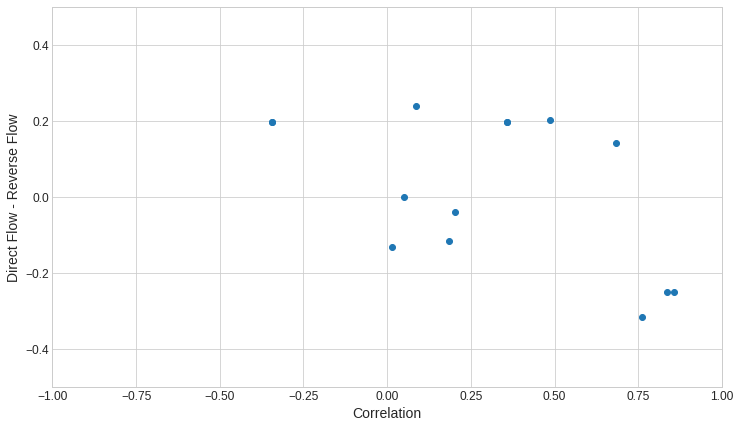

In [27]:
plt.figure(figsize=(12, 7))
plt.scatter(df_flows['correlation'], df_flows['avg_dir_flow']-df_flows['avg_rev_flow'])
plt.xlabel("Correlation", fontsize=14)
plt.ylabel("Direct Flow - Reverse Flow", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(xmin=-1, xmax=1)
plt.ylim([-0.5, 0.5])
plt.show()

In [18]:
df_flows

,name,category,avg_dir_flow,avg_rev_flow,max_dir_flow,max_rev_flow,correlation
0,breast_w,Anticausal,1.158640,1.408297,1.517554,1.526201,0.836394
1,breast_w,Anticausal,1.164062,1.414847,1.510303,1.526201,0.855487
2,breast_w,Anticausal,1.051813,1.366812,1.435261,1.526201,0.762731
3,breast_w,Anticausal,1.455172,1.314410,1.494624,1.526201,0.682452
4,balance_scale,Causal,1.576000,1.378472,1.701389,1.701389,0.358054
5,balance_scale,Causal,1.576000,1.378472,1.701389,1.701389,0.358054
6,balance_scale,Causal,1.576000,1.378472,1.701389,1.701389,-0.344940
7,balance_scale,Causal,1.576000,1.378472,1.701389,1.701389,-0.344940
8,breast_tumor,Anticausal,1.000000,1.116667,1.342723,4.766667,0.183643
9,breast_tumor,Anticausal,1.076923,1.116667,1.650000,1.458039,0.201513


In [8]:
average_flows = df_flows[['name', 'category', 'avg_dir_flow', 'avg_rev_flow']].copy()

In [9]:
category_color = {
    "Causal":'Orange',
    "Anticausal":'Blue'
}

dataframes = average_flows['name'].unique().tolist()
dataframes_symbols = ['o', 'X', 'D', 'v', '^', '<']
dataframe_category = dict(average_flows[['name', 'category']].drop_duplicates().values)

blue_patch = mpatches.Patch(color='Blue', label='Anticausal')
orange_patch = mpatches.Patch(color='Orange', label='Causal')

<function matplotlib.pyplot.show(*args, **kw)>

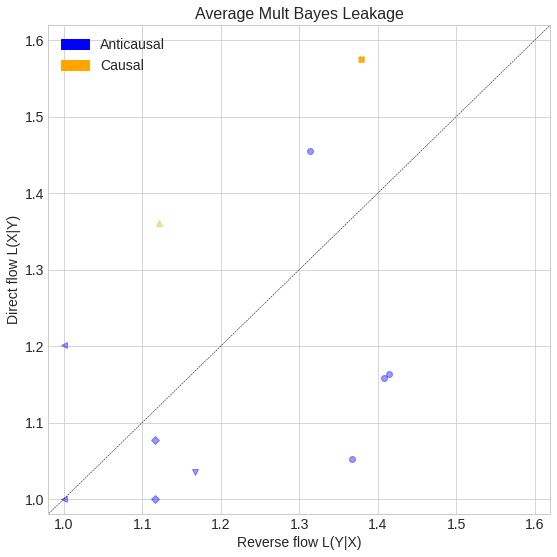

In [10]:
plt.figure(figsize=(9, 9))
for dataframe, marker in zip(dataframes, dataframes_symbols):
    df = average_flows.query("name == '{}'".format(dataframe))
    plt.plot(df['avg_rev_flow'].values,
             df['avg_dir_flow'].values,
             marker,
             color=category_color[dataframe_category[dataframe]],
             alpha=0.4)
    
plt.plot([0, 2], [0, 2], color='black', linewidth=0.5, linestyle='dashed')
plt.title("Average Mult Bayes Leakage", fontsize=16)
plt.xlabel("Reverse flow L(Y|X)", fontsize=14)
plt.ylabel("Direct flow L(X|Y)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0.98, 1.62])
plt.ylim([0.98, 1.62])
plt.legend(handles=[blue_patch, orange_patch], fontsize=14)
plt.show
#plt.savefig("avg_mult_bayes_leakage.png", dpi=120)

In [11]:
average_flows = df_flows[['name', 'category', 'max_dir_flow', 'max_rev_flow']].copy()

category_color = {
    "Causal":'Orange',
    "Anticausal":'Blue'
}

dataframes = average_flows['name'].unique().tolist()
dataframes_symbols = ['o', 'X', 'D', 'v', '^', '<']
dataframe_category = dict(average_flows[['name', 'category']].drop_duplicates().values)

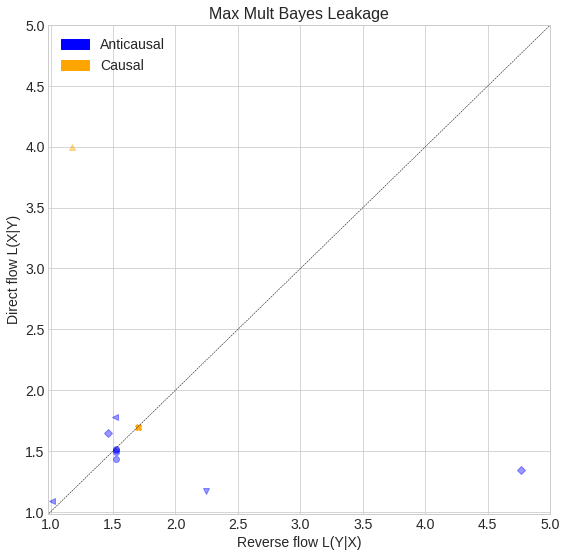

In [12]:
plt.figure(figsize=(9, 9))
for dataframe, marker in zip(dataframes, dataframes_symbols):
    df = average_flows.query("name == '{}'".format(dataframe))
    plt.plot(df['max_rev_flow'].values,
             df['max_dir_flow'].values,
             marker,
             color=category_color[dataframe_category[dataframe]],
             alpha=0.4)
    
plt.plot([0, 5], [0, 5], color='black', linewidth=0.5, linestyle='dashed')
plt.title("Max Mult Bayes Leakage", fontsize=16)
plt.xlabel("Reverse flow L(Y|X)", fontsize=14)
plt.ylabel("Direct flow L(X|Y)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)   
plt.xlim([0.98, 5])
plt.ylim([0.98, 5])
plt.legend(handles=[blue_patch, orange_patch], fontsize=14)
plt.show
plt.savefig("max_mult_bayes_leakage.png", dpi=120)

In [13]:
df_ind_flows.head()

,category,flow,leakage
0,Anticausal,direct,1.517554
1,Anticausal,direct,0.476555
2,Anticausal,reverse,1.517554
3,Anticausal,reverse,1.345126
4,Anticausal,reverse,0.899368


In [14]:
causal_dir = df_ind_flows.query("category == 'Causal' and flow == 'direct'")['leakage'].values
causal_rev = df_ind_flows.query("category == 'Causal' and flow == 'reverse'")['leakage'].values
anticausal_dir = df_ind_flows.query("category == 'Anticausal' and flow == 'direct'")['leakage'].values
anticausal_rev = df_ind_flows.query("category == 'Anticausal' and flow == 'reverse'")['leakage'].values
data = [causal_dir, causal_rev, anticausal_dir, anticausal_rev]

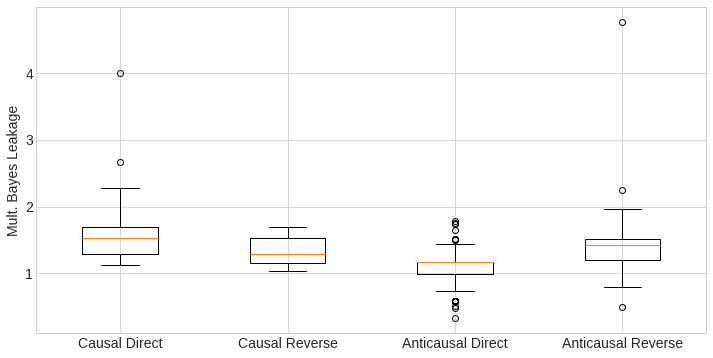

In [15]:
plt.figure(figsize=(12, 6))
plt.boxplot(data)
plt.ylabel("Mult. Bayes Leakage", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([1, 2, 3, 4], ["Causal Direct", "Causal Reverse", "Anticausal Direct", "Anticausal Reverse"], fontsize=14)
#plt.show()
plt.savefig("mult_bayes_leakage.png", dpi=120)

## Test case

In [16]:
data = [[0, 2/15, 13/15], [8/15, 6/15, 1/15]]
df1 = pd.DataFrame(data, index=['x1', 'x2'], columns=['y1', 'y2', 'y3'])

data = [[0, 5/15, 10/15], [10/15, 5/15, 0]]
df2 = pd.DataFrame(data, index=['x1', 'x2'], columns=['y1', 'y2', 'y3'])

In [17]:
print(np.round(avg_mult_bayes_leakage(df1), 2))
print(np.round(avg_mult_bayes_leakage(df1.T), 2))

1.8
1.5


In [18]:
print(np.round(avg_mult_bayes_leakage(df2), 2))
print(np.round(avg_mult_bayes_leakage(df2.T), 2))

1.67
2.0


In [3]:
data = [[1/10, 1/10, 1/5], [1/5, 2/5, 0]]
df1 = pd.DataFrame(data, index=['x1', 'x2'], columns=['y1', 'y2', 'y3'])

In [9]:
print(np.round(avg_mult_bayes_leakage(df1), 2))
print(np.round(avg_mult_bayes_leakage(df1.T), 2))

1.33
1.2
